##### Projet CO2 par Polina, Vincent, Denis

Ce notebook:
entraine un modèle de classification pour prédiction par Gradient Boosting Machines Catboost  
Prend en entrée les fichiers:
    (processed)/X_test_scaled.csv, X_train_scaled.csv, y_test_cat.csv, y_train_cat.csv : les données scalées et donc forcément préalablement séparées en jeux de train/test.

Fournit en sortie les fichiers:
    (models)/<nom_de_modele>.pkl


In [2]:
# charge les chemins vers les fichiers de données : base_processed, base_raw, base_models...
%run init_notebook.py

In [ ]:
""" !pip install seaborn 
!pip install catboost """

In [5]:
from common_co2 import load_our_data_cat, display_norm_matrix, display_roc

# Classification par Gradient Boosting Machines Catboost

In [ ]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "16"  # nombre de cœurs physiques réels

In [29]:
X_train_scaled, X_test_scaled, y_train, y_test=load_our_data_cat()

In [30]:
# Cette case est une référence pour les hyperparamètres du modèle
hyperparams = {
    'iterations': 1000,  # Nombre d'itérations
    'learning_rate': 0.1,  # Taux d'apprentissage
    'depth': 6,  # Profondeur des arbres
    'l2_leaf_reg': 3,  # Régularisation L2
    'random_seed': 42,  # Seed pour la reproductibilité
}

In [31]:
from catboost import CatBoostClassifier

# Initialiser le modèle
model = CatBoostClassifier(**hyperparams)

In [33]:
# Fonction pour entraîner le modèle
def train_model(model, X_train_scaled, y_train):
    """
    Entraîne le modèle.
    """
    model.fit(X_train_scaled, y_train, verbose=0)  # verbose=0 pour éviter trop de logs
    return model

# Fonction pour évaluer les performances du modèle
from sklearn.metrics import classification_report, f1_score, recall_score
def evaluate_model(model, X_test_scaled, y_test):
    """
    Calcule et affiche les métriques du modèle.
    """
    # Prédictions sur les données de test
    y_pred = model.predict(X_test_scaled)
    
    # Calcul et affichage de la précision
    accuracy = model.score(X_test_scaled, y_test)
    print(f"Précision du modèle : {accuracy:.3f}")
    
    # Calcul et affichage du F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' pour les classes déséquilibrées
    print(f"F1-score : {f1:.3f}")
    
    # Calcul et affichage du recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Recall : {recall:.3f}")
    
    # Affichage du rapport de classification
    report = classification_report(y_test, y_pred)
    print("Rapport de classification :")
    print(report)

    return accuracy, f1, recall, y_pred

In [ ]:
# info pour les représentations graphiques
name="CatBoost"

In [12]:
model=train_model(model, X_train_scaled, y_train)
accuracy, f1, recall, y_pred=evaluate_model(model, X_test_scaled, y_test)

Précision du modèle : 0.88
F1-score : 0.88
Recall : 0.88
Rapport de classification :
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00      2887
         2.0       0.81      0.74      0.77      1441
         3.0       0.88      0.88      0.88      6138
         4.0       0.83      0.87      0.85      5435
         5.0       0.89      0.86      0.87      5061
         6.0       0.91      0.88      0.89      2610
         7.0       0.93      0.97      0.95      1163

    accuracy                           0.88     24735
   macro avg       0.89      0.89      0.89     24735
weighted avg       0.88      0.88      0.88     24735




🔹 Matrice de confusion pour CatBoost and iterations=1000, depth=6, l2_leaf_reg=3🔹


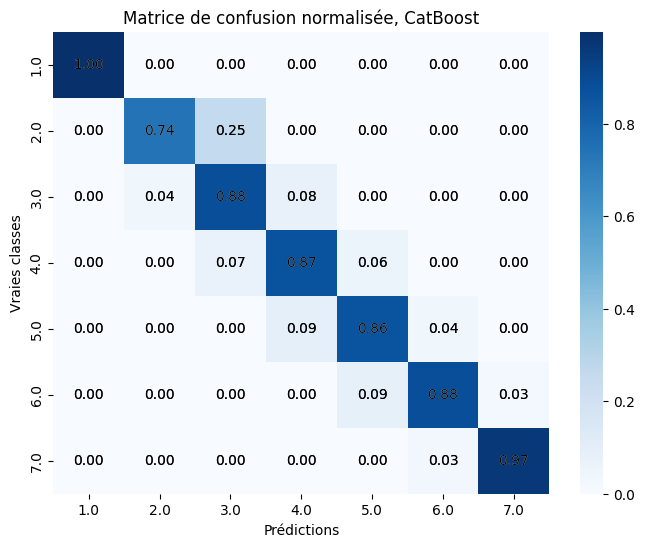

In [13]:
text_hyperparams = f"iterations={hyperparams['iterations']}, depth={hyperparams['depth']}, l2_leaf_reg={hyperparams['l2_leaf_reg']}"
display_norm_matrix(name, y_pred, y_test, text_hyperparams)
# display_confusion_matrix(model, X_test_scaled, y_test, name=name, params=hyperparams)

Quelle est la qualité du résultat ?  
Plutôt bon, mais on n'a pas encore optimisé les hyperparamètres.

In [34]:
# Nouveau set d'hyperparamètres du modèle
hyperparams = {
    'iterations': 1500,  # Nombre d'itérations
    'learning_rate': 0.1,  # Taux d'apprentissage
    'depth': 6,  # Profondeur des arbres
    'l2_leaf_reg': 2,  # Régularisation L2
    'random_seed': 42,  # Seed pour la reproductibilité
}

model = CatBoostClassifier(**hyperparams)
model=train_model(model, X_train_scaled, y_train)
accuracy, f1, recall, y_pred=evaluate_model(model, X_test_scaled, y_test)

Précision du modèle : 0.889
F1-score : 0.889
Recall : 0.889
Rapport de classification :
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00      2887
         2.0       0.80      0.75      0.78      1441
         3.0       0.88      0.89      0.88      6138
         4.0       0.85      0.87      0.86      5435
         5.0       0.89      0.87      0.88      5061
         6.0       0.91      0.89      0.90      2610
         7.0       0.93      0.96      0.95      1163

    accuracy                           0.89     24735
   macro avg       0.89      0.89      0.89     24735
weighted avg       0.89      0.89      0.89     24735




🔹 Matrice de confusion pour CatBoost and iterations=1500, depth=6, l2_leaf_reg=2🔹


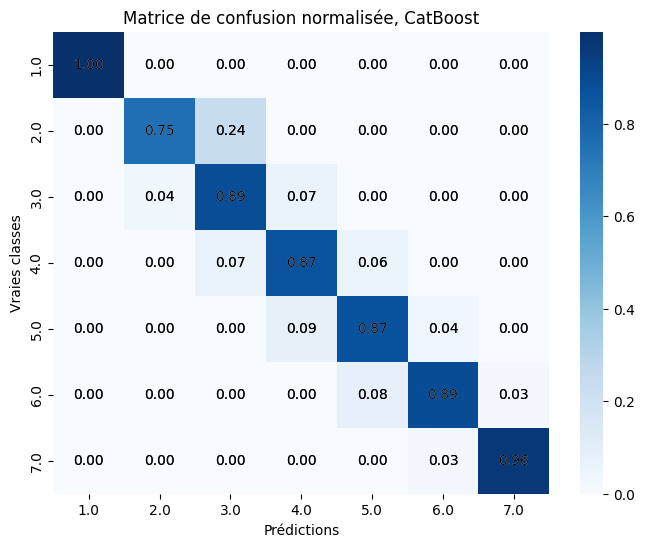

In [16]:
text_hyperparams = f"iterations={hyperparams['iterations']}, depth={hyperparams['depth']}, l2_leaf_reg={hyperparams['l2_leaf_reg']}"
display_norm_matrix(name, y_pred, y_test, text_hyperparams)
# display_confusion_matrix(model, X_test_scaled, y_test, name=name, params=hyperparams)

# Tentative d'amélioration par SMOTE

In [14]:
# Nouveau set d'hyperparamètres du modèle
hyperparams = {
    'iterations': 1500,  # Nombre d'itérations
    'learning_rate': 0.1,  # Taux d'apprentissage
    'depth': 6,  # Profondeur des arbres
    'l2_leaf_reg': 2,  # Régularisation L2
    'random_seed': 42,  # Seed pour la reproductibilité
}

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


model = CatBoostClassifier(**hyperparams)
model=train_model(model, X_train_resampled, y_train_resampled)
accuracy, f1, recall, y_pred=evaluate_model(model, X_test_scaled, y_test)


ModuleNotFoundError: No module named 'imblearn'


🔹 Matrice de confusion pour CatBoost and iterations=1500, depth=6, l2_leaf_reg=2, SMOTE🔹


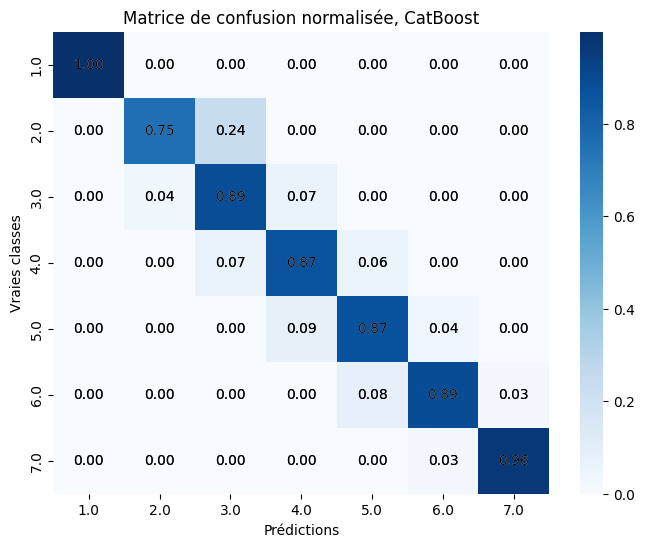

In [18]:
text_hyperparams = f"iterations={hyperparams['iterations']}, depth={hyperparams['depth']}, l2_leaf_reg={hyperparams['l2_leaf_reg']}"
text_hyperparams += f", SMOTE"
display_norm_matrix(name, y_pred, y_test, text_hyperparams)
# display_confusion_matrix(model, X_test_scaled, y_test, name=name, params=hyperparams)

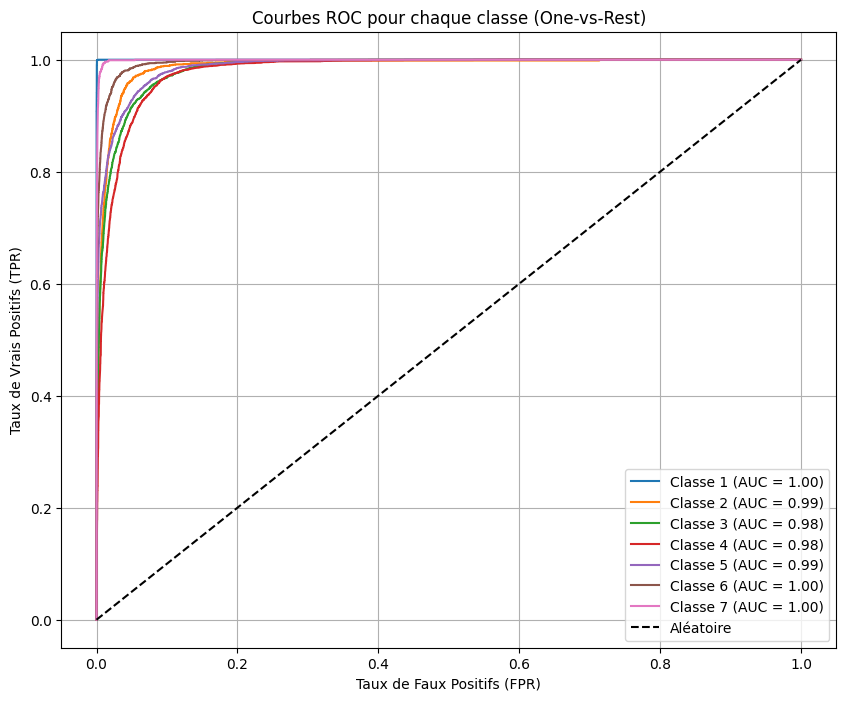

In [19]:
display_roc(X_test_scaled, y_test, y_pred, model)

# Tentative d'amélioration par pénalité

La classe 2 est sous représentée par rapport à la classe 3,  
on applique donc une pénalité aux probabilités

In [79]:
# paramètres pour ce chapitre:
threshold = 0.05 # par exemple 0.1 pour 10% de favorisation

In [80]:
# Prédire les classes sur les données de test
import numpy as np
y_prob = model.predict_proba(X_test_scaled)

y_adjusted_pred = []

# Custom logic: on priorisera class 2 si c'est celle qui est la plus probable au threshold près
for prob in y_prob:
    # La classe avec la plus haute probe est:
    max_prob_class_index = np.argmax(prob)

    # Check if class 2 is close enough to the maximum probability
    if prob[1] >= prob[max_prob_class_index] - threshold:  # Close enough to the max probability
        y_adjusted_pred.append(2)  # Favor class 2
    else:
        y_adjusted_pred.append(max_prob_class_index+1)  # Stick to the class with the highest probability


In [ ]:
# for info 
display(y_prob)
# k-NN with k=5 (our best results) is not very good for improvement by penalty,
# because the granularity of the probabilities is low.

In [82]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Calculate new metrics
adjusted_accuracy = accuracy_score(y_test, y_adjusted_pred)
adjusted_f1 = f1_score(y_test, y_adjusted_pred, average='weighted')
adjusted_recall = recall_score(y_test, y_adjusted_pred, average='weighted')  # Include recall calculation

# Print the metrics
print(f"Adjusted Accuracy: {adjusted_accuracy:.4f}")
print(f"Adjusted F1-Score: {adjusted_f1:.4f}")
print(f"Adjusted Recall: {adjusted_recall:.4f}")


Adjusted Accuracy: 0.8898
Adjusted F1-Score: 0.8897
Adjusted Recall: 0.8898


Les résultats s'améliorent avec des pénalités de 2.5% à 7%
Avec une pénalité de 5%, on a pu améliorer les scores de 0.001 point. C'est peu, mais dans la recherche de la maximisation, ça peut être retenu.


In [83]:
# pour info, les lignes qui ont bougé avec la pénalisation

# Convert y_pred to a 1D array for easier comparison
y_pred_1d = np.array(y_pred).flatten()

# Ensure y_adjusted_pred is a numpy array for consistency
y_adjusted_pred_array = np.array(y_adjusted_pred)

y_test_array=np.array(y_test)

# Compare the two arrays element-wise
differences = y_pred_1d != y_adjusted_pred_array

# Print comparison results
for i, (pred, adjusted, tst) in enumerate(zip(y_pred_1d, y_adjusted_pred_array, y_test_array)):
    if pred != adjusted:
        print(f"Difference at index {i}: y_pred = {pred}, y_adjusted_pred = {adjusted}, real={tst}")

Difference at index 507: y_pred = 3.0, y_adjusted_pred = 2, real=3.0
Difference at index 1554: y_pred = 3.0, y_adjusted_pred = 2, real=3.0
Difference at index 2300: y_pred = 3.0, y_adjusted_pred = 2, real=2.0
Difference at index 2721: y_pred = 3.0, y_adjusted_pred = 2, real=2.0
Difference at index 3042: y_pred = 3.0, y_adjusted_pred = 2, real=3.0
Difference at index 4604: y_pred = 3.0, y_adjusted_pred = 2, real=3.0
Difference at index 4672: y_pred = 3.0, y_adjusted_pred = 2, real=2.0
Difference at index 4798: y_pred = 3.0, y_adjusted_pred = 2, real=2.0
Difference at index 5356: y_pred = 3.0, y_adjusted_pred = 2, real=2.0
Difference at index 5749: y_pred = 3.0, y_adjusted_pred = 2, real=2.0
Difference at index 6050: y_pred = 3.0, y_adjusted_pred = 2, real=3.0
Difference at index 7605: y_pred = 3.0, y_adjusted_pred = 2, real=3.0
Difference at index 8512: y_pred = 3.0, y_adjusted_pred = 2, real=3.0
Difference at index 9111: y_pred = 3.0, y_adjusted_pred = 2, real=3.0
Difference at index 9


🔹 Matrice de confusion pour CatBoost and iterations=1500, depth=6, l2_leaf_reg=2, pénalité 0.05 %🔹


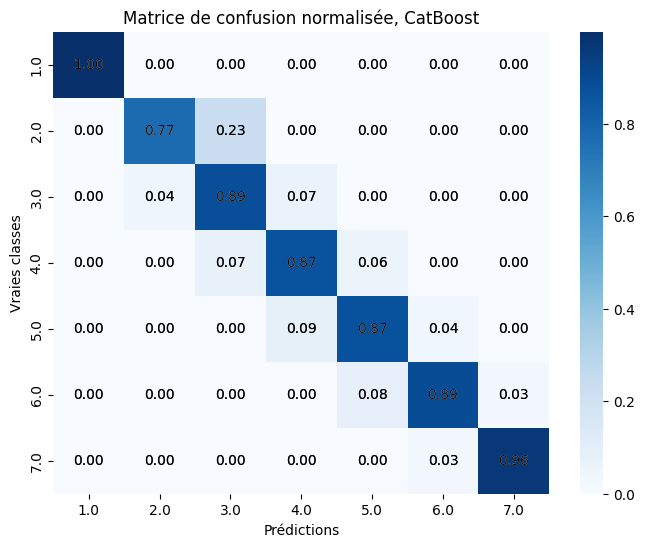

In [84]:
# affichage de la matrice
text_hyperparams = f"iterations={hyperparams['iterations']}, depth={hyperparams['depth']}, l2_leaf_reg={hyperparams['l2_leaf_reg']}"
text_hyperparams += f", pénalité {threshold} %"
display_norm_matrix(name, y_adjusted_pred, y_test, text_hyperparams)

# Sauvegarde du modèle

In [ ]:
import joblib

# Chemin pour enregistrer le modèle
model_path = base_models + 'rf_cat.pkl'

# Enregistrer le modèle
joblib.dump(random_forest_model, model_path)

print(f"Modèle random_forest enregistré dans {model_path}")
